In [4]:
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings('ignore') # Just ignore user warning
pd.options.display.max_columns = None

dataset = pd.read_csv('datatrain_complete.csv')
X = dataset.drop('flag_kredit_macet', axis=1)
y = dataset['flag_kredit_macet']

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, VotingClassifier
from lightgbm.sklearn import LGBMClassifier
from xgboost import XGBClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.model_selection import cross_val_score

LR1 = LogisticRegression(C=100, class_weight='balanced', max_iter=10, penalty='l2', random_state=1, n_jobs=-1)
LR2 = LogisticRegression(class_weight='balanced', max_iter=10, penalty='l1', random_state=1, n_jobs=-1)

KNN1 = KNeighborsClassifier(n_neighbors=5, weights='distance', p=1)

KNN2 = KNeighborsClassifier(n_neighbors=30, weights='distance', p=1)

RF1 = RandomForestClassifier(class_weight='balanced', criterion='entropy', max_depth=5, max_features='sqrt',
                             min_samples_leaf=1, min_samples_split=8, n_estimators=100, n_jobs=-1, random_state=1)

RF2 = RandomForestClassifier(class_weight='balanced',criterion='gini', max_depth=5, max_features='sqrt',
                             min_samples_leaf=1, min_samples_split=2, n_estimators=10, n_jobs=-1, random_state=1)

LGBM = LGBMClassifier(boosting_type='gbdt', class_weight='balanced', learning_rate=0.05,
                      n_estimators=100, n_jobs=-1, num_leaves=32, random_state=1)

LR_meta = LogisticRegression(max_iter=10, random_state=1, n_jobs=-1, class_weight='balanced')
RF_meta = RandomForestClassifier()

GBM = GradientBoostingClassifier(max_depth=5, random_state=1)

XGB = XGBClassifier(max_depth=6, random_state=1)

BA = BaggingClassifier(n_estimators=100, bootstrap_features=True, random_state=1, n_jobs=-1)

In [8]:
SC = StackingClassifier(classifiers=[LR1, KNN2, RF1, GBM, LGBM, XGB, BA], use_probas=True, meta_classifier=LR_meta)
VC = VotingClassifier(estimators=[('LR',LR1), ('KNN',KNN2), ('RF',RF1), ('GBM',GBM), ('LGBM',LGBM), ('XGB',XGB), ('BA',BA)],
                      voting='soft', n_jobs=-1)
VC2 = VotingClassifier(estimators=[('LR1',LR1), ('LR2',LR2), ('KNN1',KNN1), ('KNN2',KNN2), ('RF1',RF1), ('RF2',RF2),
                                   ('GBM',GBM), ('LGBM',LGBM), ('XGB',XGB), ('BA',BA)], voting='soft', n_jobs=-1)

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from scipy import interp
import numpy as np
from matplotlib.font_manager import FontProperties
import matplotlib.gridspec as grids
import matplotlib.pyplot as plt
import itertools

import warnings; warnings.filterwarnings('ignore') # Just ignore user warning

def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,size=15)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,size=12)
    # [Negative, Positive], according to confusion m benchmark
    plt.yticks(tick_marks,classes,size=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True Label',size=14)
    plt.xlabel('Predicted Label',size=14)

def cv_classifier(classifier, X, y, cv=5,
                  print_score=True, plot_rc=True, plot_cm=False):
    SKF = StratifiedKFold(n_splits=cv,shuffle=True,random_state=102)
    ytest = {}; ypred = {};
    Accuracy = []; Recall = []; Precision = []; F_one = []
    fpr = {} # False Positive Rate
    tpr = {} # True Positive Rate
    p = {} # Precision
    r = {} # Recall
    roc_auc = {} # Area Under Curve
    tprs = []; aucs = []; mean_fpr = np.linspace(0,1,100)
    j = int(0)
    print('BUILDING MODEL ======')
    for train_index, test_index in SKF.split(X,y):
        Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
        ytrain, ytest[j] = y.iloc[train_index], y.iloc[test_index]
        
        classifier.fit(Xtrain,ytrain)
        
        ypred_train = classifier.predict(Xtrain)
        acc_score_train = metrics.accuracy_score(ytrain,ypred_train) # Accuracy
        rec_score_train = metrics.recall_score(ytrain,ypred_train) # Recall
        prec_score_train = metrics.precision_score(ytrain,ypred_train) # Precision
        f1_value_train = metrics.f1_score(ytrain,ypred_train)
        
        ypred[j] = classifier.predict(Xtest)
        ypred_prob = classifier.predict_proba(Xtest)[:,1]
        # ypred_prob [:,0] => Probability Negative Class
        # ypred_prob [:,1] => Probability Positive Class
        
        # Compute FPR & TPR for ROC Curve
        fpr[j], tpr[j],_ = metrics.roc_curve(ytest[j], ypred_prob)
        # Compute Precision & Recall for Precision-Recall Curve
        p[j], r[j],_ = metrics.precision_recall_curve(ytest[j], ypred_prob)
        tprs.append(interp(mean_fpr, fpr[j], tpr[j]))
        tprs[-1][0] = 0.0
        roc_auc[j] = metrics.auc(fpr[j], tpr[j]) # Compute AUC
        aucs.append(roc_auc[j])
        acc_score = metrics.accuracy_score(ytest[j],ypred[j]) # Accuracy
        Accuracy.append(acc_score);
        rec_score = metrics.recall_score(ytest[j],ypred[j]) # Recall
        Recall.append(rec_score);
        prec_score = metrics.precision_score(ytest[j],ypred[j]) # Precision
        Precision.append(prec_score);
        f1_value = metrics.f1_score(ytest[j],ypred[j])
        F_one.append(f1_value)
        print('Step: %d-%d fold {train/test} (Acc: %0.4f/%0.4f; Rec: %0.4f/%0.4f; Prec: %0.4f/%0.4f; F1: %0.4f/%0.4f)'\
                                              % ((j+1), cv,
                                                 acc_score_train, acc_score,
                                                 rec_score_train, rec_score,
                                                 prec_score_train, prec_score,
                                                 f1_value_train, f1_value))
        j += 1
    print('=====================')
    Accuracy = np.array(Accuracy); Recall = np.array(Recall)
    Precision = np.array(Precision); F_one = np.array(F_one)
    if print_score:
        print('Average Accuracy: %0.5f' % Accuracy.mean())
        print('Average Recall: %0.5f (Hit Rate)' % Recall.mean())
        print('Average Precision: %0.5f (Positive Predictive Value)' % Precision.mean())
        print('Average F1 Score: %0.5f (0:Worst, 1:Best)' % F_one.mean())
    if plot_rc:
        plt.figure(figsize=(25,10))
        gs = grids.GridSpec(1,2)
        ax = plt.subplot(gs[0])
        for i in range(0,cv):
            plt.plot(fpr[i], tpr[i], lw=2,
                     label='ROC fold %d (AUC = %0.3f)' % (i+1,roc_auc[i]),
                     alpha=0.5)
        plt.plot([0, 1], [0, 1], color='navy', lw=2,
                 linestyle='--', label='Luck')
        mean_tpr = np.mean(tprs, axis=0);
        mean_tpr[-1] = 1.0; std_tpr = np.std(tprs, axis=0)
        mean_auc = metrics.auc(mean_fpr, mean_tpr); std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr, color='b',
                 label=r'Mean ROC (AUC = %0.2f $\pm$ %0.3f)' % (mean_auc, std_auc),
                 lw=3, alpha=1)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3,
                         label=r'$\pm$ 1 std. dev.')
        ax.set_title('Receiver Operating Characteristic Curve',size=25)
        ax.set_xlabel('False Positive Rate',size=20)
        ax.set_ylabel('True Positive Rate',size=20)
        plt.xlim(0,1); plt.ylim(0,1)
        plt.grid(linestyle='--')
        plt.tick_params(axis='both', which='major', labelsize=20)
        plt.legend(loc="lower right",prop = FontProperties(size=15))    
        ax = plt.subplot(gs[1])
        for i in range(0,cv):
            plt.step(r[i], p[i], lw=2,
                     label='PR fold %d' % (i+1),
                     alpha=0.5)
        ax.set_title('Precision-Recall Curve',size=25)
        ax.set_xlabel('Recall (Hit Rate)',size=20)
        ax.set_ylabel('Precision (Positive Predictive Value)',size=20)
        plt.xlim(0,1); plt.ylim(0,1)
        plt.grid(linestyle='--')
        plt.tick_params(axis='both', which='major', labelsize=20)
        plt.legend(loc="upper right",prop = FontProperties(size=15))
        plt.show()
    if plot_cm:
        index_max = np.where(Accuracy==Accuracy.max())[0][0]
        Ytrue = ytest[index_max]
        Ypred = ypred[index_max]
        cm = metrics.confusion_matrix(Ytrue,Ypred)
        print('Total Data Used : %d' % len(Ytrue))
        plot_confusion_matrix(cm, ['No','Yes'], title='Confusion Matrix',
                              cmap=plt.cm.Blues)

BUILDING MODEL ======
Step: 1-10 fold {train/test} (Acc: 0.9902/0.9174; Rec: 0.9166/0.3235; Prec: 0.9697/0.5500; F1: 0.9424/0.4074)
Step: 2-10 fold {train/test} (Acc: 0.9898/0.9026; Rec: 0.9117/0.3088; Prec: 0.9704/0.4242; F1: 0.9401/0.3574)
Step: 3-10 fold {train/test} (Acc: 0.9898/0.9026; Rec: 0.9117/0.2721; Prec: 0.9704/0.4157; F1: 0.9401/0.3289)
Step: 4-10 fold {train/test} (Acc: 0.9906/0.9097; Rec: 0.9182/0.2868; Prec: 0.9731/0.4756; F1: 0.9449/0.3578)
Step: 5-10 fold {train/test} (Acc: 0.9907/0.9032; Rec: 0.9191/0.2941; Prec: 0.9740/0.4255; F1: 0.9457/0.3478)
Step: 6-10 fold {train/test} (Acc: 0.9902/0.9083; Rec: 0.9133/0.3015; Prec: 0.9730/0.4659; F1: 0.9422/0.3661)
Step: 7-10 fold {train/test} (Acc: 0.9895/0.8941; Rec: 0.9150/0.2500; Prec: 0.9638/0.3542; F1: 0.9388/0.2931)
Step: 8-10 fold {train/test} (Acc: 0.9897/0.9116; Rec: 0.9101/0.3603; Prec: 0.9704/0.4949; F1: 0.9392/0.4170)
Step: 9-10 fold {train/test} (Acc: 0.9897/0.9032; Rec: 0.9125/0.3162; Prec: 0.9679/0.4300; F1: 0.9

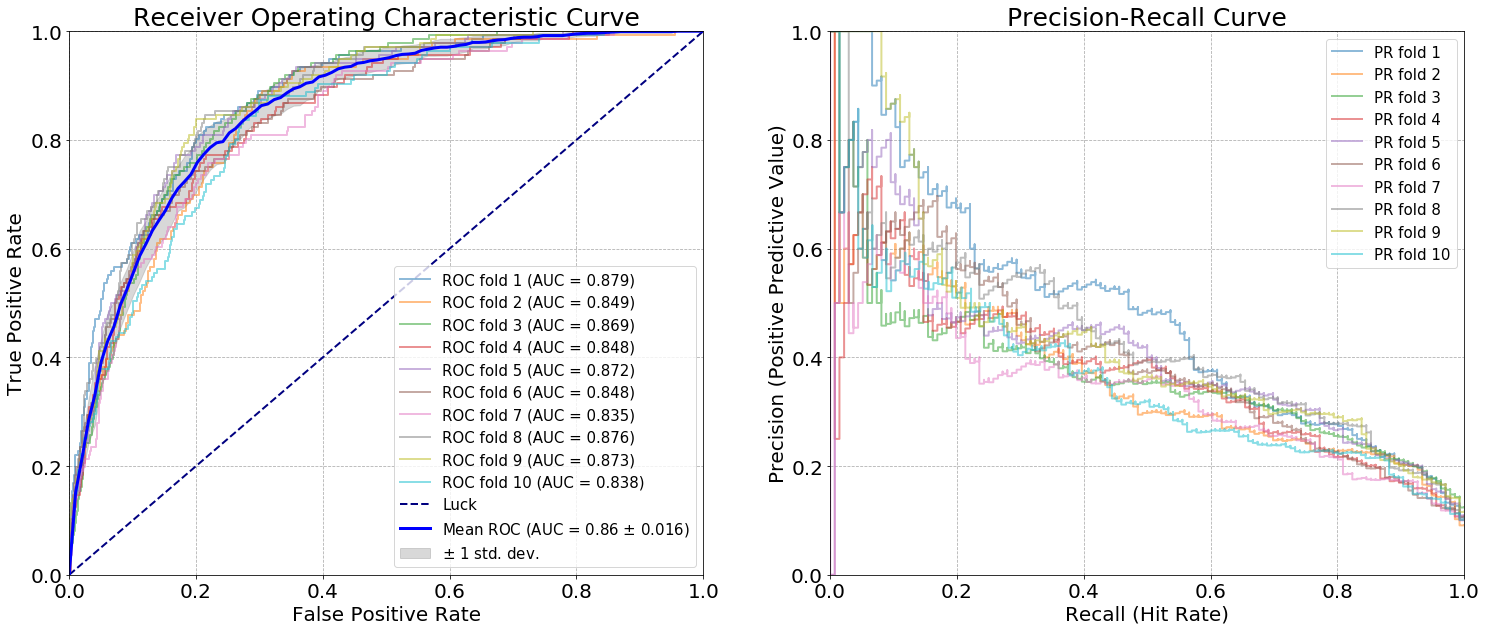

Total Data Used : 1550
Confusion matrix, without normalization


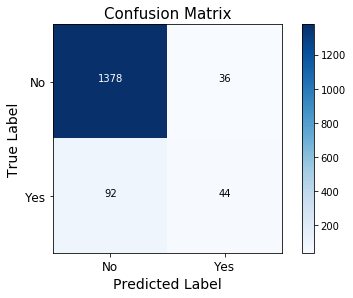

In [10]:
# BA = BaggingClassifier(n_estimators=100, bootstrap_features=True, random_state=1, n_jobs=-1)
cv_classifier(VC, X, y, cv=10, print_score=True, plot_rc=True, plot_cm=True)